In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from pathlib import Path

# Example image
### Full image

In [2]:
data_path = "../SOCOFing/Real/"

In [3]:
def ax_remove_borders(ax):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
def show_image(image):
    fig, ax = plt.subplots(1, 1)
    ax_remove_borders(ax)
    ax.imshow(image)

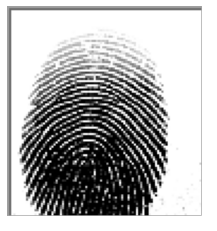

In [4]:
im = Image.open(f'{data_path}1__M_Left_little_finger.BMP')
show_image(im)

In [5]:
single_image_size = np.array(im.size)
print(im.format, single_image_size, im.mode)

BMP [ 96 103] RGBA


### Image part

In [6]:
vertical_parts = 3
horizontal_parts = 3
part_size_percent = 0.7
part_size = (single_image_size * part_size_percent).astype(int)
print(part_size)

[67 72]


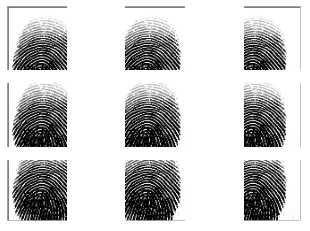

In [7]:
(leftover_width, leftover_height) = single_image_size - part_size

fig, ax = plt.subplots(vertical_parts, horizontal_parts)
for x in range(vertical_parts):
    for y in range(horizontal_parts):
        ax_remove_borders(ax[x, y])
        box = np.array([
            y * leftover_width / (horizontal_parts - 1), 
            x * leftover_height / (vertical_parts - 1)
        ]).astype(int)
        box = (*box, *(box + part_size))
        region = im.crop(box)
        ax[x, y].imshow(region)

### Image part augmentation

In [8]:
max_rotation = 15
max_perspective = 0.25
positive_noise_strength = 0.2
negative_noise_strength = 0.4
fade_at_edges_strength = 0.8

https://stackoverflow.com/questions/14177744/how-does-perspective-transformation-work-in-pil
https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/

In [9]:
def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])
        
    A = np.matrix(matrix, dtype=np.float)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

#### Rotation and perspective

In [12]:
def augment_rotation(image, max_rotation):
    return image.rotate(np.random.randint(-max_rotation, max_rotation))

def adjust_points(x, y, width, height):
    x1 = x + (-1 if x > 0 else 1) * np.random.uniform(0, max_perspective) * width
    y1 = y + (-1 if y > 0 else 1) * np.random.uniform(0, max_perspective) * height
    return x1, y1

def augment_perspective(image, max_perspective):
    width, height = im_augmented.size
    points = [(0, 0), (width, 0), (width, height), (0, height)]
    new_points = [adjust_points(x, y, width, height) for x, y in points]
    coeffs = find_coeffs(points, new_points)
    return image.transform(image.size, Image.PERSPECTIVE, coeffs, Image.BICUBIC)

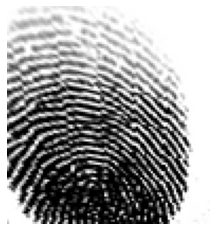

In [13]:
im_augmented = augment_rotation(im, max_rotation)

im_augmented = augment_perspective(im_augmented, max_perspective)

show_image(im_augmented)

#### Cutting part with proper size

In [14]:
def crop_random_part(image, part_size):
    (leftover_width, leftover_height) = image.size - part_size
    box = np.array([np.random.randint(leftover_width), np.random.randint(leftover_height)])
    box = (*box, *(box + part_size))
    return image.crop(box)

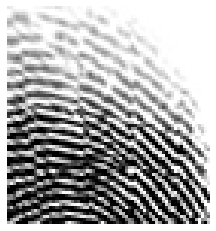

In [15]:
region = crop_random_part(im_augmented, part_size)

show_image(region)

In [16]:
im_arr = np.array(region)

#### Noise

In [17]:
def augment_noise(image_array, negative_noise_strength, positive_noise_strength):
    new_array = np.empty(shape=image_array.shape, dtype=image_array.dtype)
    width, height, _ = image_array.shape
    noise = (np.random.randint(-255 * negative_noise_strength, 255 * positive_noise_strength, (width, height)) 
             if negative_noise_strength != positive_noise_strength else np.zeros(shape=(width, height)))
    for x in range(width):
        for y in range(height):
            value = min(255, max(0, image_array[x, y][0] + noise[x, y]))
            new_array[x, y] = np.array([value, value, value, image_array[x, y][3]])
    return new_array

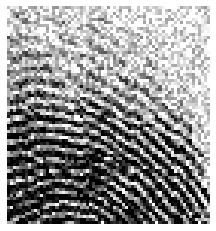

In [18]:
im_arr = augment_noise(im_arr, negative_noise_strength, positive_noise_strength)
new_im = Image.fromarray(im_arr)
show_image(new_im)

#### Fade at the edges

In [19]:
def augment_fade_at_edges(image_array, strength, function="linear"):
    new_array = np.empty(shape=image_array.shape, dtype=image_array.dtype)
    width, height, _ = im_arr.shape
    mid_width, mid_height = width / 2, height / 2
    mid = np.array([mid_width, mid_height])
    max_distance = np.linalg.norm(np.array([0, 0]) - mid)
    
    f = ((lambda x: np.sin(np.pi / 2 * x)) if function == "sin" else 
        (lambda x: -np.log(-0.9 * x + 1)) if function == "log" else 
        (lambda x: x))
    
    for x in range(width):
        for y in range(height):
            distance = np.linalg.norm(np.array([x, y]) - mid)
            percent_distance = distance / max_distance
            percent_added_value = f(percent_distance)
            added_value = 255 * percent_added_value * fade_at_edges_strength
            value = min(255, image_array[x, y][0] + added_value)
            new_array[x, y] = np.array([value, value, value, image_array[x, y][3]])
    
    return new_array

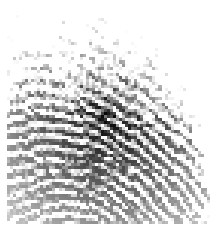

In [20]:
# linear fade

new_arr = augment_fade_at_edges(im_arr, fade_at_edges_strength)
new_im = Image.fromarray(new_arr)
show_image(new_im)

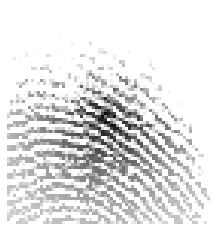

In [21]:
# sinus fade

new_arr = augment_fade_at_edges(im_arr, fade_at_edges_strength, function="sin")
new_im = Image.fromarray(new_arr)
show_image(new_im)

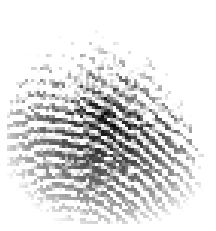

In [22]:
# log fade

new_arr = augment_fade_at_edges(im_arr, fade_at_edges_strength, function="log")
new_im = Image.fromarray(new_arr)
show_image(new_im)

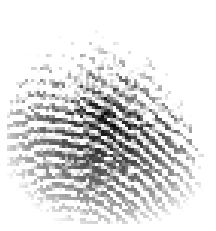

In [23]:
im_arr = augment_fade_at_edges(im_arr, fade_at_edges_strength, function="log")
new_im = Image.fromarray(new_arr)
show_image(new_im)

# Augmenting whole dataset

In [31]:
hand_names = ["Left", "Right"]
finger_names = ["index", "little", "middle", "ring", "thumb"]
sex_names = ["M", "F"]
numbers = [i + 1 for i in range(600)]
save_dir_name = "augmented_parts"

In [25]:
def get_image_name(number, hand_name, finger_name):
    for sex_name in sex_names:
        name = f'{number}__{sex_name}_{hand_name}_{finger_name}_finger'
        if os.path.isfile(f'{data_path}{name}.BMP'):
            return name
        
def augment_image_part(image,
                       part_size = part_size,
                       max_rotation = max_rotation,
                       max_perspective = max_perspective,
                       positive_noise_strength = positive_noise_strength, 
                       negative_noise_strength = negative_noise_strength,
                       fade_at_edges_strength = fade_at_edges_strength,
                       fade_function="log",
                       show_steps=False):
    if show_steps: show_image(image)
        
    augmented = augment_rotation(image, max_rotation)
    if show_steps: show_image(augmented)
        
    augmented = augment_perspective(augmented, max_perspective)
    if show_steps: show_image(augmented)
        
    augmented = crop_random_part(augmented, part_size)
    if show_steps: show_image(augmented)
        
    arr = np.array(augmented)
    arr = augment_noise(arr, negative_noise_strength, positive_noise_strength)
    if show_steps: show_image(Image.fromarray(arr))
        
    arr = augment_fade_at_edges(arr, fade_at_edges_strength, function=fade_function)
    if show_steps: show_image(Image.fromarray(arr))
        
    return Image.fromarray(arr)

In [27]:
sizes = dict()

for number in numbers:
    for hand_name in hand_names:
        for finger_name in finger_names:
            image_name = get_image_name(number, hand_name, finger_name)
            with Image.open(f'{data_path}{image_name}.BMP') as im:
                single_image_size = np.array(im.size)
                size = im.size
                if not size in sizes:
                    sizes[size] = 1
                else:
                    sizes[size] += 1

commmon_size, highest_count = None, 0

for size, count in sizes.items():
    print("size:", size, "count:", count)
    if count > highest_count:
        common_size = size
        highest_count = count
        
print("common size:", common_size)

size: (96, 103) count: 5956
size: (241, 298) count: 44
common size: (96, 103)


In [28]:
def resize_image_to_common_size(image):
    if image.size != common_size:
        return image.resize(common_size, resample=Image.LANCZOS)
    return image

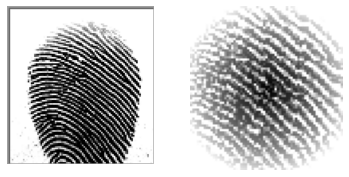

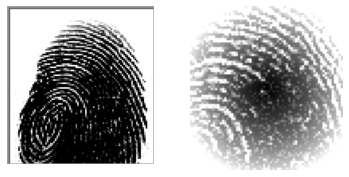

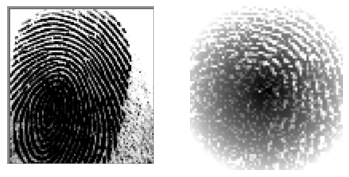

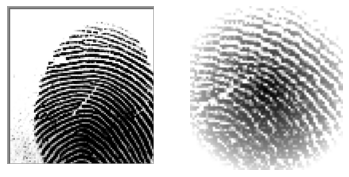

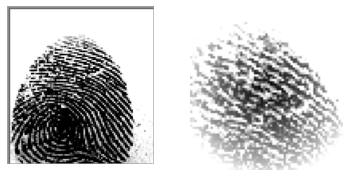

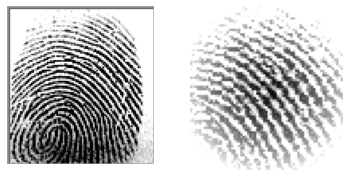

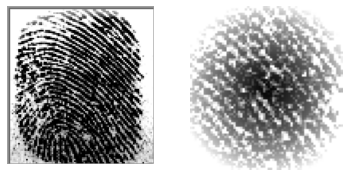

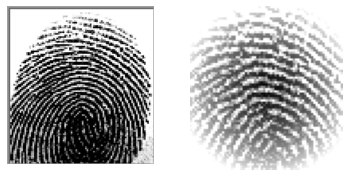

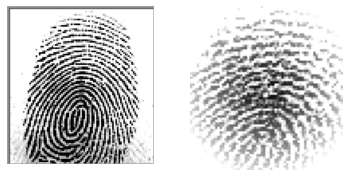

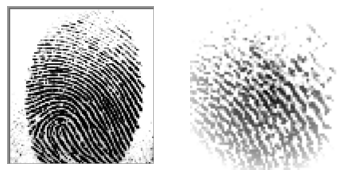

In [32]:
Path(f"./{save_dir_name}").mkdir(parents=True, exist_ok=True)

example_images = []

for number in numbers:
    for hand_name in hand_names:
        for finger_name in finger_names:
            for i in range(3):
                image_name = get_image_name(number, hand_name, finger_name)
                with Image.open(f'{data_path}{image_name}.BMP') as im:
                    im = resize_image_to_common_size(im)
                    if im.mode != "RGBA":
                        im = im.convert("RGBA")

                    augmented_im = augment_image_part(im)
                    augmented_im.save(f'./{save_dir_name}/{image_name}_a{i}.BMP')

                    if i == 0 and number % 60 == 0 and hand_name == "Right" and finger_name == "index":
                        example_images += [(im, augmented_im)]
                
for im, augmented in example_images:
    fig, ax = plt.subplots(1, 2)
    ax_remove_borders(ax[0])
    ax_remove_borders(ax[1])
    ax[0].imshow(im)
    ax[1].imshow(augmented)